In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import pydot
import graphviz

2025-04-12 02:43:37.268602: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Class names: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']


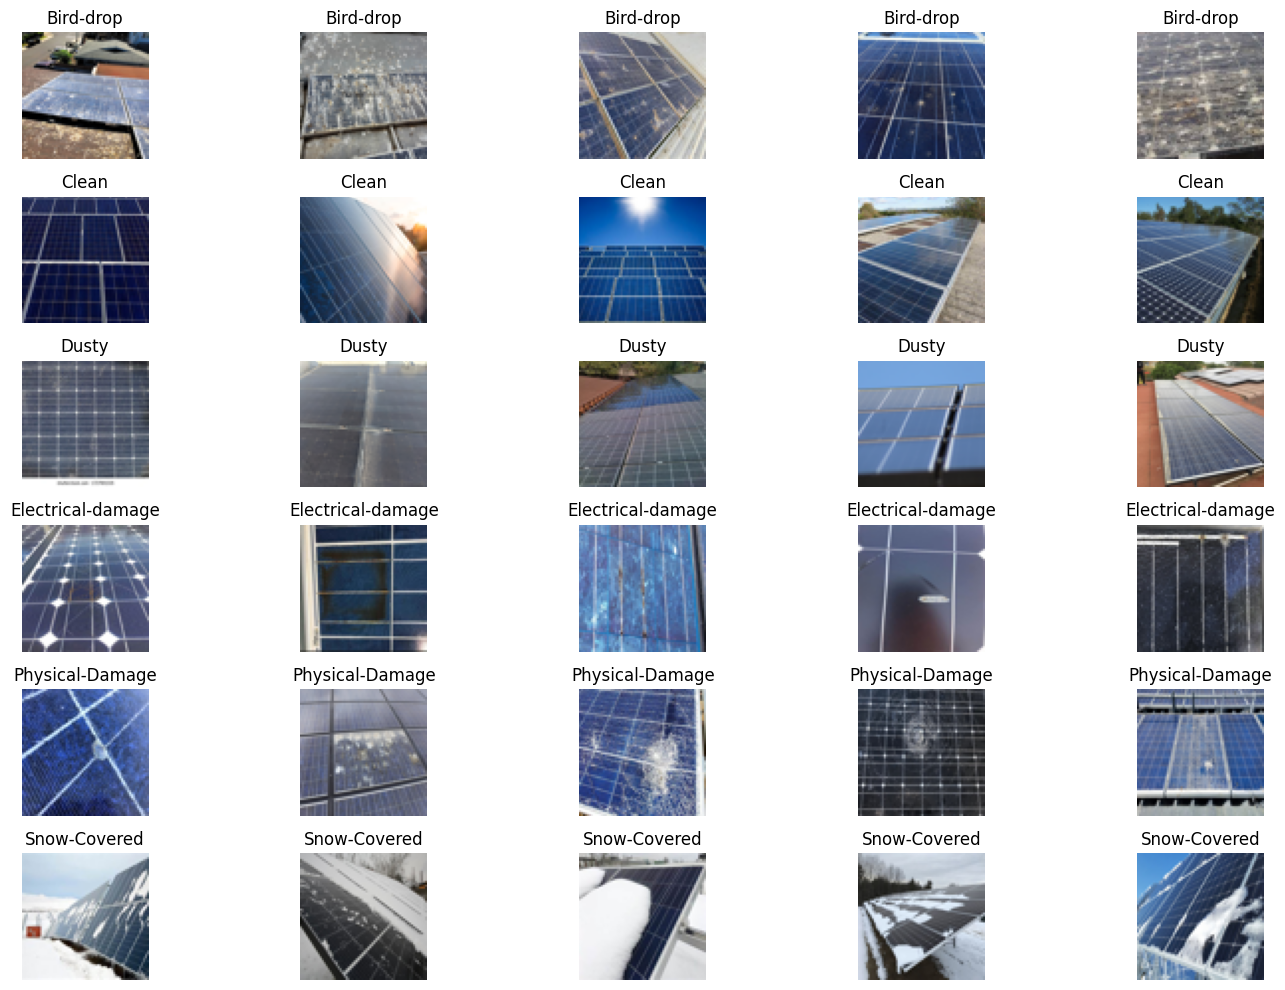

In [2]:
# 1. Load and process dataset
import zipfile
with zipfile.ZipFile("archive.zip", "r") as zip_ref:
    zip_ref.extractall("archive")

data_path = "archive/Faulty_solar_panel"
IMG_SIZE = (64, 64)
categories = sorted(os.listdir(data_path))
label_map = {cat: idx for idx, cat in enumerate(categories)}

print("Class names:", categories)

# Display sample training images
plt.figure(figsize=(15, 10))
count = 0
rows, cols = 6, 5  # 6 categories × 5 images = 30 subplots

for category in categories:
    folder = os.path.join(data_path, category)
    files = os.listdir(folder)[:5]  # first 5 files per class
    for file in files:
        img = Image.open(os.path.join(folder, file)).resize((64, 64))
        ax = plt.subplot(rows, cols, count + 1)
        plt.imshow(img)
        plt.title(category)
        plt.axis("off")
        count += 1

plt.tight_layout()
plt.show()


def load_images_from_directory(base_path, label_map, img_size=(64, 64)):
    images, labels = [], []
    for category in label_map:
        folder = os.path.join(base_path, category)
        for file in os.listdir(folder):
            try:
                img = Image.open(os.path.join(folder, file)).convert('RGB').resize(img_size)
                images.append(np.array(img))
                labels.append(label_map[category])
            except:
                continue
    return np.array(images), np.array(labels)

X, y = load_images_from_directory(data_path, label_map)
X = X.astype('float32') / 255.0
y_cat = to_categorical(y, num_classes=6)
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, stratify=y)


In [3]:
# 2. CNN Model
def build_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(6, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [31]:
# 3. Conditional GAN
class ConditionalGAN(tf.keras.Model):
    def __init__(self, num_classes=6, latent_dim=100):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()

    def build_generator(self):
        noise = tf.keras.Input(shape=(self.latent_dim,))
        label = tf.keras.Input(shape=(1,), dtype='int32')
        label_embedding = layers.Embedding(self.num_classes, self.latent_dim)(label)
        label_embedding = layers.Flatten()(label_embedding)
        model_input = layers.multiply([noise, label_embedding])

        x = layers.Dense(8*8*256, use_bias=False)(model_input)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Reshape((8, 8, 256))(x)
        x = layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2DTranspose(32, (5,5), strides=(2,2), padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2DTranspose(16, (5,5), strides=(1,1), padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        img = layers.Conv2DTranspose(3, (5,5), strides=(1,1), padding='same', use_bias=False, activation='tanh')(x)
        return tf.keras.Model([noise, label], img)

    def build_discriminator(self):
        img = tf.keras.Input(shape=(64, 64, 3))
        label = tf.keras.Input(shape=(1,), dtype='int32')
        label_embedding = layers.Embedding(self.num_classes, 64*64*3)(label)
        label_embedding = layers.Flatten()(label_embedding)
        label_embedding = layers.Reshape((64, 64, 3))(label_embedding)
        merged = layers.Concatenate()([img, label_embedding])

        x = layers.Conv2D(64, (5,5), strides=(2,2), padding='same')(merged)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Conv2D(128, (5,5), strides=(2,2), padding='same')(x)
        x = layers.LeakyReLU()(x)
        x = layers.Dropout(0.3)(x)
        x = layers.Flatten()(x)
        validity = layers.Dense(1)(x)
        return tf.keras.Model([img, label], validity)

# Initialize and compile
latent_dim = 100
cgan = ConditionalGAN(num_classes=6, latent_dim=latent_dim)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(images, labels):
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_images = cgan.generator([noise, labels], training=True)
        real_output = cgan.discriminator([images, labels], training=True)
        fake_output = cgan.discriminator([gen_images, labels], training=True)

        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
        disc_loss = cross_entropy(tf.ones_like(real_output), real_output) + \
                    cross_entropy(tf.zeros_like(fake_output), fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, cgan.generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, cgan.discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, cgan.generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, cgan.discriminator.trainable_variables))
    return gen_loss, disc_loss

def train_cgan(X_train, y_train, epochs=50, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((X_train, tf.argmax(y_train, axis=1))).shuffle(1000).batch(batch_size)
    for epoch in range(epochs):
        gen_losses = []
        disc_losses = []
        for image_batch, label_batch in dataset:
            g_loss, d_loss = train_step(image_batch, tf.expand_dims(label_batch, axis=1))
            gen_losses.append(g_loss)
            disc_losses.append(d_loss)
        print(f"Epoch {epoch+1}/{epochs} | Generator Loss: {np.mean(gen_losses):.4f} | Discriminator Loss: {np.mean(disc_losses):.4f}")


In [43]:
# 4. Train GAN
train_cgan(X_train, y_train, epochs=5000)

Epoch 1/5000 | Generator Loss: 1.2061 | Discriminator Loss: 2.1915
Epoch 2/5000 | Generator Loss: 1.6224 | Discriminator Loss: 1.0507
Epoch 3/5000 | Generator Loss: 1.6296 | Discriminator Loss: 1.0939
Epoch 4/5000 | Generator Loss: 1.2066 | Discriminator Loss: 1.5636
Epoch 5/5000 | Generator Loss: 0.8124 | Discriminator Loss: 1.6541
Epoch 6/5000 | Generator Loss: 1.1011 | Discriminator Loss: 1.0227
Epoch 7/5000 | Generator Loss: 0.9098 | Discriminator Loss: 1.3375
Epoch 8/5000 | Generator Loss: 1.3303 | Discriminator Loss: 1.0384
Epoch 9/5000 | Generator Loss: 1.1808 | Discriminator Loss: 1.5728
Epoch 10/5000 | Generator Loss: 0.7463 | Discriminator Loss: 1.6021
Epoch 11/5000 | Generator Loss: 0.8341 | Discriminator Loss: 1.2087
Epoch 12/5000 | Generator Loss: 1.1129 | Discriminator Loss: 1.0171
Epoch 13/5000 | Generator Loss: 1.1831 | Discriminator Loss: 0.9019
Epoch 14/5000 | Generator Loss: 1.2284 | Discriminator Loss: 0.9070
Epoch 15/5000 | Generator Loss: 1.4221 | Discriminator Lo

In [44]:
# 5. Generate Synthetic Data for Augmentation
num_gen = 1000
noise = tf.random.normal([num_gen, latent_dim])
labels_to_generate = np.random.randint(0, 6, size=(num_gen, 1))
generated_images = cgan.generator.predict([noise, labels_to_generate])
generated_images = (generated_images + 1) / 2

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


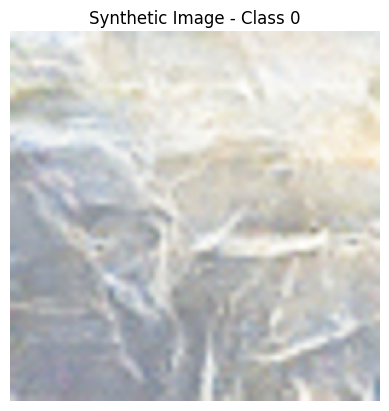

In [47]:
# 6. Visualize one for presentation
class_id = 0
upscaled = Image.fromarray((generated_images[0]*255).astype(np.uint8)).resize((256,256), resample=Image.BICUBIC)
plt.imshow(upscaled)
plt.title(f"Synthetic Image - Class {class_id}")
plt.axis('off')
plt.show()

In [58]:
# 7. Combine and Train CNN with Augmented Data
gen_labels_cat = to_categorical(labels_to_generate, num_classes=6)
X_aug = np.concatenate([X_train, generated_images])
y_aug = np.concatenate([y_train, gen_labels_cat])

cnn_aug = build_cnn()
history = cnn_aug.fit(X_aug, y_aug, epochs=1000, validation_data=(X_test, y_test))

Epoch 1/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 136ms/step - accuracy: 0.2227 - loss: 4.6800 - val_accuracy: 0.1897 - val_loss: 3.0363
Epoch 2/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2698 - loss: 1.7987 - val_accuracy: 0.1149 - val_loss: 3.4449
Epoch 3/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3442 - loss: 1.6089 - val_accuracy: 0.2184 - val_loss: 3.8971
Epoch 4/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3779 - loss: 1.5297 - val_accuracy: 0.2184 - val_loss: 4.8080
Epoch 5/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4106 - loss: 1.4576 - val_accuracy: 0.2471 - val_loss: 3.3016
Epoch 6/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5081 - loss: 1.2722 - val_accuracy: 0.2701 - val_loss: 2.4139
Epoch 7/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5422 - loss: 1.1680 - val_accuracy: 0.3391 - val_loss: 2.1078
Epoch 8/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5632 - loss: 1.1375 - val_accuracy

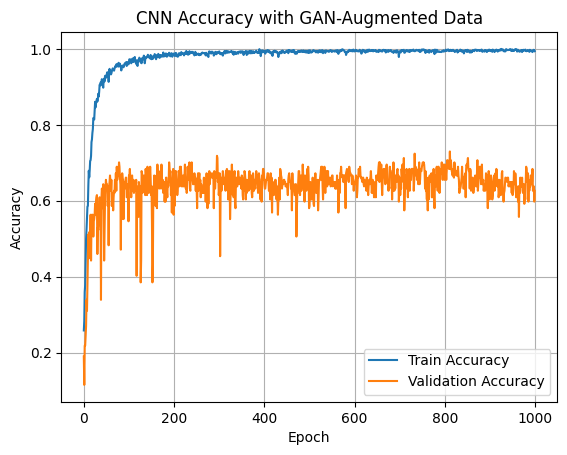

In [59]:
# 8. Plot CNN accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy with GAN-Augmented Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()